# Exploratory Data Analysis
We'll start by importing packages, reading the data into a dataframe, and checking the datatypes and for nulls. Convenience functions have been written separately so as not to clog up the notebook unnecessarily; see `utils.py` for details.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import datetime
import utils


# FONT_SIZE_TICKS = 15
# FONT_SIZE_TITLE = 20
# FONT_SIZE_AXES = 17

# colors = {'white': '#fdfdfd',
#           'dark blue': '#06072c',
#           'chalk blue': '#5f85a6',
#           'light gray': '#cfd1d4',
#           'blue gray': '#a3aab5',
#           'black': '#000000'}

# COLORS = [v for v in colors.values()]

# sns.set_palette(sns.color_palette(COLORS))


In [2]:
raw = pd.read_csv('data/raw.csv')
raw.head()

,Location,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Season,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
0,Camp Murray,20171203,1145,47.11,-122.57,84,2.017120e+11,12,11,Winter,81.71997,12.86919,2.42769,5,10.0,1010.6,722
1,Camp Murray,20171203,1315,47.11,-122.57,84,2.017120e+11,12,13,Winter,96.64917,9.66415,2.46273,0,10.0,1011.3,23
2,Camp Murray,20171203,1330,47.11,-122.57,84,2.017120e+11,12,13,Winter,93.61572,15.44983,4.46836,5,10.0,1011.6,32
3,Camp Murray,20171204,1230,47.11,-122.57,84,2.017120e+11,12,12,Winter,77.21558,10.36659,1.65364,5,2.0,1024.4,6
4,Camp Murray,20171204,1415,47.11,-122.57,84,2.017120e+11,12,14,Winter,54.80347,16.85471,6.57939,3,3.0,1023.7,9


The following line tidies the various time-related columns and inserts a datatime column for time-series visualisation later on. 

In [3]:
raw = utils.fix_dates(raw)
raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Datetime       21045 non-null  datetime64[ns]
 1   Location       21045 non-null  object        
 2   Latitude       21045 non-null  float64       
 3   Longitude      21045 non-null  float64       
 4   Altitude       21045 non-null  int64         
 5   Season         21045 non-null  object        
 6   Humidity       21045 non-null  float64       
 7   AmbientTemp    21045 non-null  float64       
 8   Wind.Speed     21045 non-null  int64         
 9   Visibility     21045 non-null  float64       
 10  Pressure       21045 non-null  float64       
 11  Cloud.Ceiling  21045 non-null  int64         
 12  PolyPwr        21045 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(3), object(2)
memory usage: 2.1+ MB


From above, there are no nulls. However, the data is collected over 499 days from 23 May 2017 to 4 Oct 2018 in 15-minute intervals between 10:00 and 15.45. Assuming an ideal situation of a reading every 15 minutes over this period, we have a ceiling of 6 * 4 * 499 = 11976 possible readings per location and can compare the actual counts with this, as shown below. It's clear that the data collected is quite patchy, with a maximum of 23% of data points present in Travis, which would have to be addressed if we go ahead with time-series modelling later on.

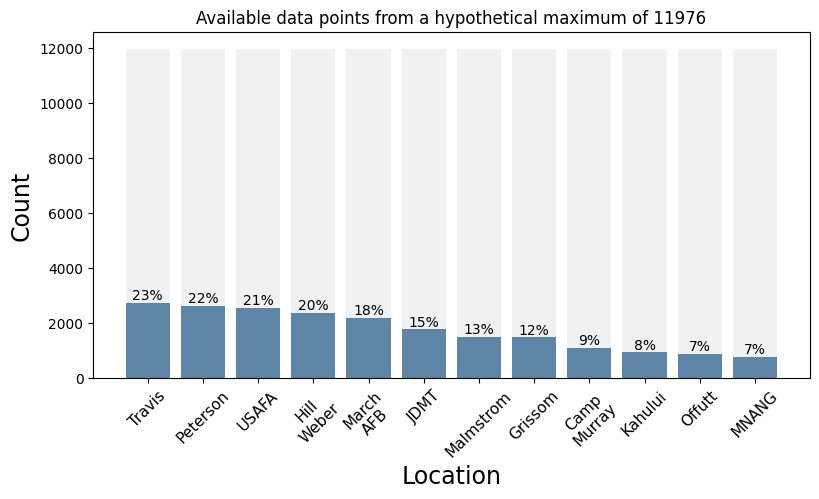

In [4]:
utils.visualise_missing_data(raw)

### Discrepancy between descriptive statistics here and in the paper
Calculating descriptive statistics for the numerical columns, it's noted that the values here differ from those in the paper for some of the features (see `variable units.png`). After investigating, the differences were due to approximately constant scaling factors for each feature, indicating some change of units had taken place. The function `fix_units()` calculates these and transforms the features accordingly. The second set of statistics is then left closely matching those in the paper.

In [5]:
numerical_features = [f for f in raw.columns if f not in ['Datetime', 'Season', 'Latitude', 'Longitude', 'Location']]

raw[numerical_features].describe().round(3).loc[['min', '25%', '50%', 'mean', '75%', 'max']].T

,min,25%,50%,mean,75%,max
Altitude,1.000,2.000,458.000,798.844,1370.000,1947.000
Humidity,0.000,17.529,33.124,37.122,52.594,99.988
AmbientTemp,-19.982,21.915,30.289,29.285,37.475,65.738
Wind.Speed,0.000,6.000,9.000,10.318,14.000,49.000
Visibility,0.000,10.000,10.000,9.700,10.000,10.000
Pressure,781.700,845.500,961.100,925.945,1008.900,1029.500
Cloud.Ceiling,0.000,140.000,722.000,515.967,722.000,722.000
PolyPwr,0.257,6.405,13.799,12.979,18.864,34.285


In [6]:
raw_clean = utils.fix_units(raw)

raw_clean[numerical_features].describe().round(3).loc[['min', '25%', '50%', 'mean', '75%', 'max']].T

,min,25%,50%,mean,75%,max
Altitude,0.303,0.607,138.932,242.325,415.582,590.612
Humidity,0.000,17.529,33.124,37.122,52.594,99.988
AmbientTemp,-19.982,21.915,30.289,29.285,37.475,65.738
Wind.Speed,0.000,9.665,14.497,16.621,22.551,78.929
Visibility,0.000,16.096,16.096,15.614,16.096,16.096
Pressure,781.700,845.500,961.100,925.945,1008.900,1029.500
Cloud.Ceiling,0.000,4.272,22.029,15.743,22.029,22.029
PolyPwr,0.257,6.405,13.799,12.979,18.864,34.285


With that done, we can rename the column headings and include the appropriate units.

In [7]:
raw_clean.columns = ['Datetime', 'Location', 'Latitude (deg)', 'Longitude (deg)', 'Altitude (m)', 'Season',
       'Humidity (%)', 'AmbientTemp (deg C)', 'WindSpeed (km/h)', 'Visibility (km)', 'Pressure (mbar)',
       'CloudCeiling (km)', 'Power (W)']

numerical_features = [f for f in raw_clean.columns if f not in ['Datetime', 'Season', 'Latitude (deg)', 'Longitude (deg)', 'Altitude (m)', 'Location']]

The following plots can be used to compare the distributions of various numerical features at each location, individually or side-by-side. We see that the power output, the target variable, often exhibits approximately bimodal distributions with the locations of the central peaks varying from site to site and with peak frequency occurring at high power in some cases (e.g. USAFA) and low power in others (e.g. Malmstrom). It can be seen from the violin/box plots that all features vary substantially with location. 

In [8]:
utils.compare_box_violins(raw_clean, numerical_features)

interactive(children=(Dropdown(description='Feature', index=6, options=('Humidity (%)', 'AmbientTemp (deg C)',…

In [9]:
utils.compare_histograms(raw_clean, numerical_features, bins=64)

interactive(children=(Dropdown(description='Location 1', index=10, options=('Camp Murray', 'Grissom', 'Hill We…

In [10]:
utils.scatterplot(raw_clean, numerical_features)

interactive(children=(Dropdown(description='Location', index=11, options=('Camp Murray', 'Grissom', 'Hill Webe…

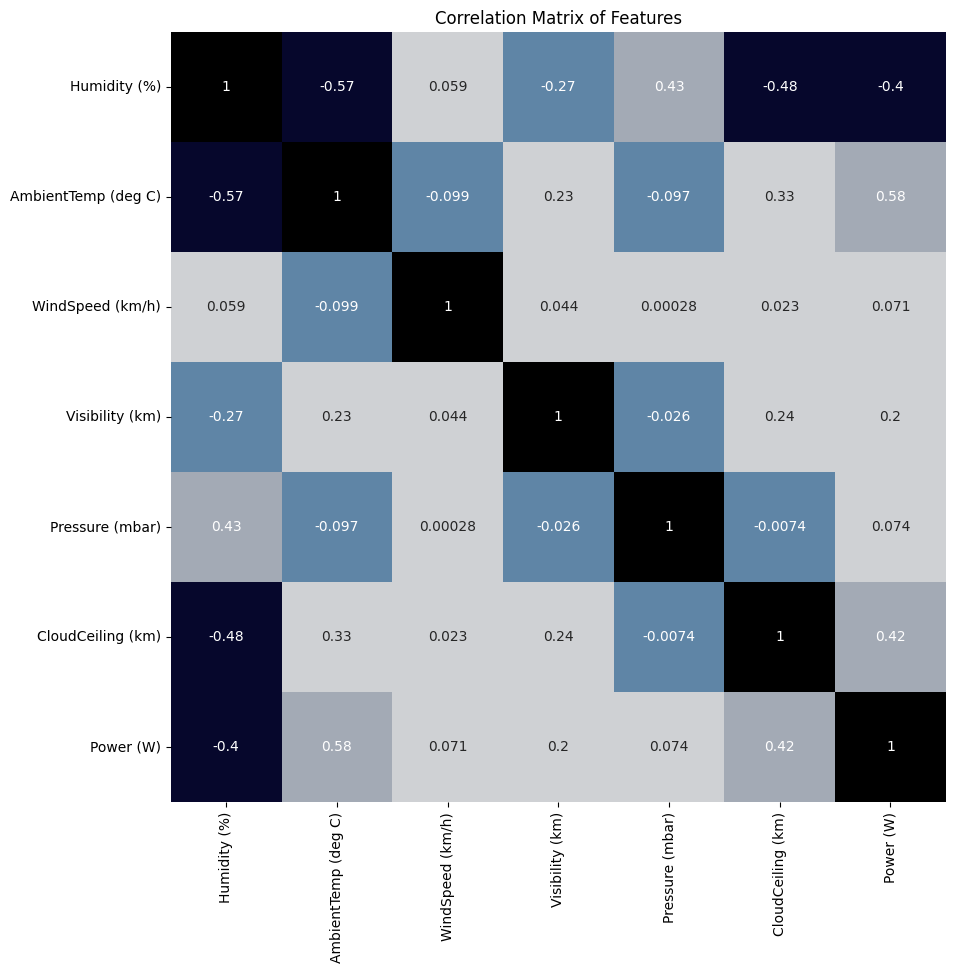

In [11]:
utils.correlation_matrix(raw_clean[numerical_features])

In [12]:
utils.plot_time_series(raw_clean, numerical_features)

interactive(children=(Dropdown(description='Location', index=11, options=('Camp Murray', 'Grissom', 'Hill Webe…

In [13]:
raw_clean.head()

,Datetime,Location,Latitude (deg),Longitude (deg),Altitude (m),Season,Humidity (%),AmbientTemp (deg C),WindSpeed (km/h),Visibility (km),Pressure (mbar),CloudCeiling (km),Power (W)
0,2017-12-03 11:45:00,Camp Murray,47.11,-122.57,25.480965,Winter,81.71997,12.86919,8.053964,16.096495,1010.6,22.028990,2.42769
1,2017-12-03 13:15:00,Camp Murray,47.11,-122.57,25.480965,Winter,96.64917,9.66415,0.000000,16.096495,1011.3,0.701755,2.46273
2,2017-12-03 13:30:00,Camp Murray,47.11,-122.57,25.480965,Winter,93.61572,15.44983,8.053964,16.096495,1011.6,0.976354,4.46836
3,2017-12-04 12:30:00,Camp Murray,47.11,-122.57,25.480965,Winter,77.21558,10.36659,8.053964,3.219299,1024.4,0.183066,1.65364
4,2017-12-04 14:15:00,Camp Murray,47.11,-122.57,25.480965,Winter,54.80347,16.85471,4.832378,4.828948,1023.7,0.274600,6.57939


In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import folium 
from colour import Color
from collections import defaultdict
import numpy as np
import seaborn as sns
import base64

FONT_SIZE_TICKS = 15
FONT_SIZE_TITLE = 20
FONT_SIZE_AXES = 17

colors = {'white': '#fdfdfd',
          'dark blue': '#06072c',
          'chalk blue': '#5f85a6',
          'light gray': '#cfd1d4',
          'blue gray': '#a3aab5',
          'black': '#000000'}

COLORS = [v for v in colors.values()]

sns.set_palette(sns.color_palette(COLORS))


def create_map_with_plots(full_data: pd.core.frame.DataFrame, x_variable: str, y_variable: str='Power (W)') -> folium.Map:
    '''
    Create a map to visualize geo points. The popup will show a scatterplot with the average daily/hourly emisions.
        
    Args:
        full_data (pd.core.frame.DataFrame): The dataframe with the data.
        x_variable (str): The x variable on the popup plot. can be day_of_week or hour_of_day
        y_variable (str): A pollutant to be shown on y axis
    
    '''

    data = full_data[['Latitude (deg)', 'Longitude (deg)', y_variable, 'Location', x_variable]]
    data_grouped = data.groupby(['Location', x_variable]).agg(({y_variable: ['mean', 'std']}))
    ymin = data_grouped[y_variable]['mean'].min()
    ymax = data_grouped[y_variable]['mean'].max()

    grouped_means = defaultdict(dict)
    grouped_stds = defaultdict(dict)
    for index, row in data_grouped.iterrows():
        grouped_means[index[0]][index[1]] = row[0]
        grouped_stds[index[0]][index[1]] = row[1]

    for key in grouped_means:
        if (x_variable == 'day_of_week'):
            keys = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
            label = 'daily average'
        else:
            keys = list(grouped_means[key].keys())
            label = 'hourly average'

        values = []
        stds = []
        for subkey in keys:
            values.append(grouped_means[key][subkey])
            stds.append(grouped_stds[key][subkey])
        values = np.array(values)
        stds = np.array(stds)
        plt.plot(keys, values, '-o', label=label)
        plt.fill_between(keys, values - stds, values + stds, alpha=0.2)
        if y_variable == 'PM2.5':
            plt.plot(keys, [12]*len(keys),'--g', label='recommended level')
        plt.plot(keys, [np.average(values)]*len(keys), '--b', label='annual average')
        
        plt.ylim(ymin, ymax)
        plt.title(f'Location {key} avg. {y_variable} / {x_variable.split("_")[0]}')
        plt.ylabel(f'Avg. {y_variable} concentration')
        plt.xlabel(x_variable[0].upper() + x_variable[1:].replace('_', ' '))
        plt.legend(loc="upper left")
        if (x_variable == 'day_of_week'):
            plt.xticks(rotation=20)
        plt.savefig(f'img/tmp/{key}.png')

        plt.clf()
    
    data_grouped_grid = data.groupby('Location').agg(({y_variable: 'mean', 'Latitude (deg)': 'min', 'Longitude (deg)': 'min'}))
    
    data_grouped_grid_array = np.array(
        [
            data_grouped_grid['Latitude (deg)'].values,
            data_grouped_grid['Longitude (deg)'].values,
            data_grouped_grid[y_variable].values,
            data_grouped_grid.index.values
        ]
    ).T

    map3 = folium.Map(
        location=[data_grouped_grid_array[0][0], data_grouped_grid_array[0][1]],
        tiles='openstreetmap',
        zoom_start=11,
        width=1000,
        height=500
    )

    fg = folium.FeatureGroup(name="My Map")
    for lt, ln, power, location in data_grouped_grid_array:
        fg.add_child(folium.CircleMarker(location=[lt, ln], radius = 15, popup=f"<img src='img/tmp/{location}.png'>",
        # fill_color=color_producer(y_variable, pol), color = '', fill_opacity=0.5))
        fill_color='blue', color='', fill_opacity=0.5))
        map3.add_child(fg)
    return map3

In [86]:
df = raw_clean.copy()

x_variable = 'month_of_year' # Options ['day_of_week', 'hour_of_day']

# choose a pollutant which you are interested in
y_variable = 'Power (W)' # Options ['PM2.5', 'PM10', 'NO', 'NO2', 'NOX', 'CO', 'OZONE']


df['month_of_year'] = pd.DatetimeIndex(df['Datetime']).month
df['hour_of_day'] = pd.DatetimeIndex(df['Datetime']).hour
df.loc[df['hour_of_day']==0,'hour_of_day'] = 24

# create_map_with_plots(df, x_variable, y_variable)

In [91]:
months = {
    1: 'J',
    2: 'F',
    3: 'M',
    4: 'A',
    5: 'M',
    6: 'J',
    7: 'J',
    8: 'A',
    9: 'S',
    10: 'O',
    11: 'N',
    12: 'D'
}

data = df[['Latitude (deg)', 'Longitude (deg)', y_variable, 'Location', x_variable]].copy()
data_grouped = data.groupby(['Location', x_variable]).agg(({y_variable: ['mean', 'std']}))
ymin = data_grouped[y_variable]['mean'].min()
ymax = data_grouped[y_variable]['mean'].max()

grouped_means = defaultdict(dict)
grouped_stds = defaultdict(dict)

for index, row in data_grouped.iterrows():
    grouped_means[index[0]][index[1]] = row[0]
    grouped_stds[index[0]][index[1]] = row[1]

for key in grouped_means:
    if (x_variable == 'month_of_year'):
        keys = list(grouped_means[key].keys())
        label = 'monthly average'
    else:
        keys = list(grouped_means[key].keys())
        label = 'hourly average'

    values, stds = [], []
    for subkey in keys:
        values.append(grouped_means[key][subkey])
        stds.append(grouped_stds[key][subkey])
    print(keys)
    values = np.array(values)
    stds = np.array(stds)
    plt.plot(keys, values, '-o', label=label, color=COLORS[2])
    plt.fill_between(keys, values - stds, values + stds, alpha=0.2, color=COLORS[3])
    # if y_variable == 'Power (W)':
    #     plt.plot(keys, [12]*len(keys),'--g', label='recommended level')
    plt.plot(keys, [np.average(values)]*len(keys), '--b', label='annual average')
    
    plt.ylim(ymin, ymax)
    plt.title(f'Location {key} avg. {y_variable} / {x_variable.split("_")[0]}')
    plt.ylabel(f'Avg. {y_variable}')
    plt.xlabel(x_variable[0].upper() + x_variable[1:].replace('_', ' '))
    plt.legend(loc="upper left")
    # if (x_variable == 'month_of_year'):
    #     plt.xticks(range(len(keys)), labels=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'], fontsize=11, rotation=45)
    plt.savefig(f'img/tmp/{key}.png', dpi=50)

    plt.clf()

data_grouped_grid = data.groupby('Location').agg(({y_variable: 'mean', 'Latitude (deg)': 'min', 'Longitude (deg)': 'min'}))

data_grouped_grid_array = np.array(
    [
        data_grouped_grid['Latitude (deg)'].values,
        data_grouped_grid['Longitude (deg)'].values,
        data_grouped_grid[y_variable].values,
        data_grouped_grid.index.values
    ]
).T

map3 = folium.Map(
    location=[37.519934, -114.6],
    tiles='openstreetmap',
    zoom_start=3.5,
    width=1000,
    height=500
)

# resolution, width, height = 10, 2, 2
width = 300
height = 300
fg = folium.FeatureGroup(name="My Map")
for lt, ln, power, location in data_grouped_grid_array:
    enc = base64.b64encode(open(f"img/tmp/{location}.png", 'rb').read())
    html = "<img src='data:image/png;base64,{}'>".format
    iframe = folium.IFrame(html(enc.decode('UTF-8', errors='ignore')), width=width+20, height=height+20)
    popup = folium.Popup(iframe, max_width=300, max_height=250)
    fg.add_child(folium.CircleMarker(location=[lt, ln], radius = 15, popup=popup,
    # fill_color=color_producer(y_variable, pol), color = '', fill_opacity=0.5))
    fill_color=COLORS[1], color='', fill_opacity=0.5))
    map3.add_child(fg)
    
map3


/var/folders/wb/5h7cs7g51ts3ndjm9x6xjjcr0000gn/T/ipykernel_47773/530978881.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped_means[index[0]][index[1]] = row[0]
/var/folders/wb/5h7cs7g51ts3ndjm9x6xjjcr0000gn/T/ipykernel_47773/530978881.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped_stds[index[0]][index[1]] = row[1]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 4, 5, 6, 11, 12]
[2, 3, 4, 5, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]


<Figure size 640x480 with 0 Axes>

In [78]:
[m for m in 'JFMAMJJASOND']

['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']